In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.fft import fft, ifft
from scipy.optimize import line_search
from tensorflow.python import tf2
from keras.datasets import mnist
from scipy.linalg import convolution_matrix
from PIL import Image, ImageOps
import time


In [19]:
K = np.diag(np.array([1,2,3]))
M = np.diag(np.array([7,8,9]))
N = np.array([[1,2,3],[4,5,6],[7,8,9]])
NtN = N.T @ N
print(N@K)

[[ 1  4  9]
 [ 4 10 18]
 [ 7 16 27]]


## Forward-Backward
We will use FB to minimize the function
$$f(x) + g(x) = \frac{1}{2 \lambda}\|Ax-y\|_2^2 + \|x\|_1$$
Let us for the time being omit the $\frac{1}{2\lambda}$ term. For the Forward-Backward method, we require $\nabla f$.
We can find this using directional derivatives. Rewriting, we have
$$f(x) = \|Ax-y\|_2^2 = (Ax-y)^T(Ax-y) = x^TA^TAx - 2x^TA^Ty + y^Ty.$$
The directional derivative of $f$ along $v$ is
$$\nabla_v f(x) = \lim_{h \xrightarrow{} 0} \frac{f(x+hv) - f(x)}{h}$$
$$= \lim_{h \xrightarrow{} 0} \frac{(x+hv)^TA^TA(x+hv) - 2(x+hv)^TA^Ty + y^Ty - x^TA^TAx + 2x^TA^Ty - y^Ty}{h}$$
$$
= \lim_{h \xrightarrow{} 0} 2x^TA^tAv + hv^TA^TAv - 2v^TA^Ty = v^T(2A^TAx - 2A^Ty).
$$
However, from Taylor expansion we also have
$$\nabla_v f(x) = \lim_{h \xrightarrow{} 0} \frac{f(x+hv) - f(x)}{h} \approx \lim_{h \xrightarrow{} 0} \frac{f(x) + hv^T\nabla f(x) - f(x)}{h} = v^T \nabla f(x).$$
Hence from the previous equation we also have
$$\nabla_v f(x) = v^T(2A^TAx - 2A^Ty) = v^T \nabla f(x),$$
and so
$$\nabla f(x) = 2A^TAx - 2A^Ty.$$
Now, the Forward-Backward Algorithm is given to us as
$$x_{n+1} = prox_{\gamma R}\left(x_n - \gamma \nabla f(x_n)\right).$$
In the case that $R(x) = \|x\|_1$, we have
$$prox_{\gamma R}(x) = sign(x) \max{(|x|-\gamma,0)}.$$
Hence, for our current loss function, we have the F-B iteration
$$x_{n+1} = prox_{\gamma R}\left(x_n - \frac{\gamma}{\lambda}\left(A^TAx - A^Ty\right)\right),$$
with $prox$ as above.

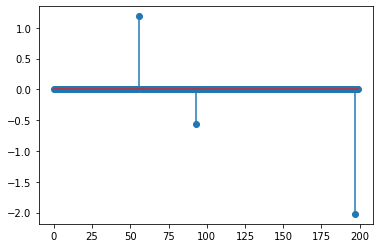

In [4]:
#Initializations
features = 100;
samples = 200;
A = np.random.randn(features,samples)
#Try different matrices
#y = np.random.randn(features)
#Initialize some random sparse solution
x0 = np.zeros((samples,1))
p = np.random.permutation(samples)
x0[p[:3]] = np.random.randn(3,1)
x0 = np.reshape(x0,-1)
y = A@x0
#lam = .9 * np.max( np.abs(A.T @ y))
lam = np.max(np.abs(A.T@y))/10
plt.stem(x0)
plt.show()

In [36]:
np.size(x0)

200

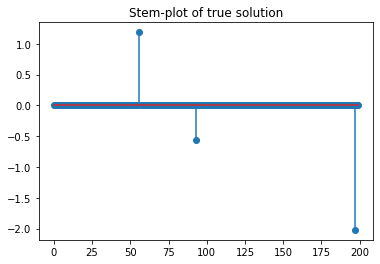

In [37]:
fig, ax = plt.subplots( nrows=1, ncols=1 )
ax.stem(x0)
ax.set_title('Stem-plot of true solution')
plt.savefig('foo.png')

In [5]:
def errL2(A,x,y):   #Return L2 error of Ax-y
    dif = A@x - y
    return dif.T @ dif

In [6]:
def funcreg(A,x,y,lam):    #Return f(x)+g(x)
    dif = A@x - y
    fxgx = (1/(2*lam))* (dif.T @ dif) + np.linalg.norm(x,1)
    return fxgx

In [7]:
#Implement thresh/prox function for g(x) = ||1||_1
def prox(x,lam): 
    return np.sign(x) * np.maximum(np.abs(x)-lam*np.ones(np.size(x)),0)

In [8]:
def GradF(A,x,y):                   #Calculate gradient of ||Ax-y||_2^2
    return (((A.T @ A) @ x) - A.T @ y)

In [9]:
def SubdifTest(A,x,y,lam):          #Subdifferential Test to check for correct solution
    gradf = GradF(A,x,y)/lam
    return max(abs(gradf))

Time for 5000 iterations: 1.8142783641815186 seconds
Final f(x)+g(x): 3.4290917911677647
Original soln: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.18786787  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0

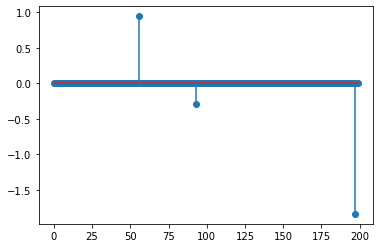

Text(0.5, 1.0, 'ln(G(x)) vs Iterations)')

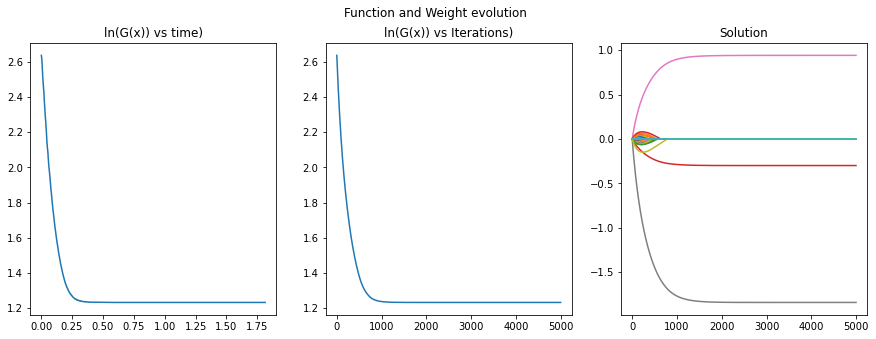

In [96]:
#Implement Forward Backward alg
#initialize x_0 = 0
x = np.zeros(samples)
niter = 5000
xtemp = np.zeros((samples,niter))
errvec = np.zeros(niter)
funcvec_fb = np.zeros(niter)
omg = .1/np.linalg.norm(A)
time_fb = np.zeros(niter)
start = time.time()
for i in range(niter):
    #print("Iteration", i)
    x = prox(x - (omg/lam)*(np.dot(np.matmul(A.T,A),x) - np.dot(A.T,y)),omg)
    #fftx = np.fft.fft(x,10000)
    #fftdiff = fftk * fftx - ffty
    #gradconv = np.fft.ifft(fftkc * fftdiff,samples)
    #x = prox(x - (omg/lam)*gradconv,omg)
    xtemp[:,i] = x
    errvec[i] = errL2(A,x,y)
    funcvec_fb[i] = funcreg(A,x,y,lam)
    time_fb[i] = time.time() - start

end = time.time()

print('Time for', niter, 'iterations:', end - start, 'seconds')
print("Final f(x)+g(x):", funcvec_fb[-1])
print("Original soln:", x0)
print("|x-x0|_0 =", np.linalg.norm(x-x0,0))
print("Subdifferential:", SubdifTest(A,x,y,lam))
plt.stem(x)
plt.show()

fig, axs = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Function and Weight evolution')
axs[0].plot(time_fb, np.log(funcvec_fb.T));
axs[0].set_title('ln(G(x)) vs time)')
axs[2].plot(xtemp.T);
axs[2].set_title('Solution')
axs[1].plot(np.log(funcvec_fb.T));
axs[1].set_title('ln(G(x)) vs Iterations)')

## Gradient Descent
Now, by Theorem 2 in the paper, we have that $(\mathcal{P}_\lambda)$ is equivalent to
$$\min_{v \in \mathbb{R}^k} f(v) \triangleq \min_{u \in \mathbb{R}^n} G(u,v) = \frac{1}{2} h(v \odot v) + \frac{1}{2}\|u\|_2^2 + \frac{1}{\lambda}L \left(X(v \odot_{\mathcal{G}} u),y \right).$$

We will use $h(v \odot v) = \|v\|_2^2$ and $L$ as above. By Corollary 1, $u$ solves
$$(diag(v) X^TX diag(v) + \lambda I)u = v \odot_{\mathcal{G}} (X^Ty),$$
so that
$$u = (diag(v) X^TX diag(v) + \lambda I)^{-1} (v \odot_{\mathcal{G}} (X^Ty)).$$

In order to solve $\min_{v \in \mathbb{R}^k} f(v)$ by Gradient Descent, we find $\nabla f = \frac{\partial f}{\partial v}:$
$$\frac{\partial f}{\partial v} = \partial_v G(u,v) = v + \frac{1}{\lambda} \partial_v L.$$ Now, using chain rule, we have that, denoting $\omega = (v \odot_{\mathcal{G}} u),$
$$\frac{\partial L}{\partial v_i} = \nabla L \cdot \frac{\partial \omega}{\partial v_i},$$
that is
$$\frac{\partial L}{\partial v_i} = \frac{1}{\lambda}\left(X^TX (v \odot_{\mathcal{G}} u) - X^Ty \right) \cdot u',$$
where $u' = (0, \ldots, u_g, \ldots, 0)$. The above can also be reformulated (as per Proposition 3) as
$$\nabla f = v + \frac{1}{\lambda} \left( u \odot (X^\top X (v \odot_{\mathcal{G}} u) - X^\top y) \right)$$
We can now apply Gradient Descent.

In [11]:
def find_u(X,y,v,lam): 
    invm =  np.diag(v) @ (X.T @ (X @ np.diag(v))) + lam * np.eye(np.size(v))
    return np.linalg.inv(invm) @ (np.multiply(v,X.T @ y))

In [12]:
def Gradf(X,y,v,lam):
    u = find_u(X,y,v,lam)
    tempvec = v + (1/lam) * ( u * (X.T @ (X @ (v*u)) - X.T @ y))
    return tempvec

Time for 5000 iterations: 39.023500204086304 seconds
Final f(x)+g(x): 3.4290917910836867
Final soln: [ 3.14698911e-48 -1.22068951e-44 -6.76828349e-38  4.73996142e-44
 -1.97688642e-43 -1.30442927e-44  4.72286351e-44 -1.84354183e-43
 -4.66135495e-47 -3.40020285e-44 -8.83695871e-44  4.09671875e-44
  4.33815197e-42 -3.91618901e-46 -8.91198761e-46  7.81320579e-44
  7.60945517e-48 -2.92490807e-42  1.39774262e-45 -7.46445552e-42
 -4.95900313e-46  1.20281353e-40 -1.40020058e-39 -1.25936078e-45
 -3.42245075e-43 -4.46944889e-45  5.57556075e-46  1.86920162e-42
  3.82616036e-42 -3.55851187e-45 -1.21702613e-45  1.72994233e-45
  1.41746817e-44  1.31951117e-45 -2.76165473e-45 -3.00190396e-43
 -2.17083632e-44 -3.78722383e-45  6.25885850e-49 -1.37980512e-45
 -4.73956736e-45 -4.43140772e-42  4.66251660e-45  3.50455784e-45
  9.89121941e-49  8.61987289e-48 -3.35434252e-43 -1.01437860e-44
  2.23300970e-45 -4.13390161e-45  2.00099521e-44 -2.45014872e-46
  7.06041539e-45  7.90581868e-42 -8.69234828e-45  9.28

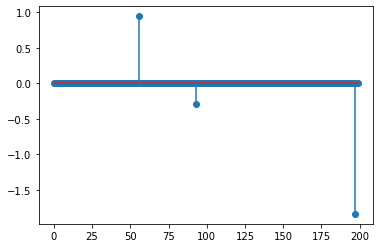

Text(0.5, 1.0, 'Solution')

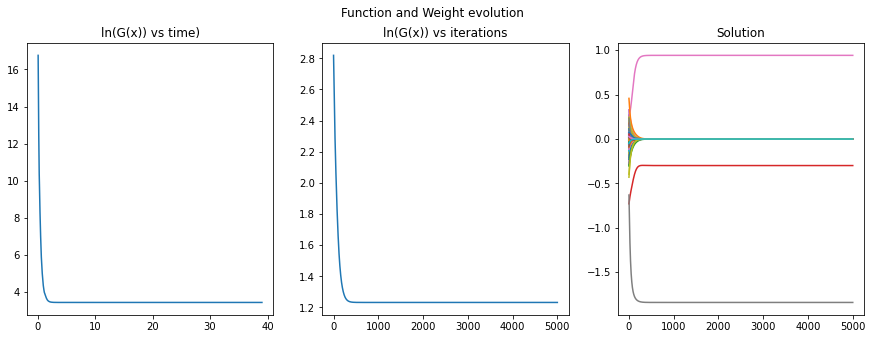

In [100]:
step = 0.01
niter = 5000
errvec2 = np.zeros(niter)
funcvec_gdu = np.zeros(niter)
v = np.random.randn(samples)
#v = np.zeros(samples)
xtemp2 = np.zeros((samples,niter))
time_gdu = np.zeros(niter)
start = time.time()
for i in range(niter):
    #print("Iteration", i)
    grad = Gradf(A,y,v,lam)
    #grad = Gradf_conv(A,fftk,fftkc,y,v,lam)
    v = v - step*grad
    x = v * find_u(A,y,v,lam)
    #x = v * find_u_conv(fftk,fftkc,ffty,v,lam)
    xtemp2[:,i] = x
    errvec2[i] = errL2(A,x,y)
    funcvec_gdu[i] = funcreg(A,x,y,lam)
    time_gdu[i] = time.time() - start
    
end = time.time()

print('Time for', niter, 'iterations:', end - start, 'seconds')
    
print("Final f(x)+g(x):", funcvec_gdu[-1])
print("Final soln:", x)
print("Subdifferential:", SubdifTest(A,x,y,lam))
plt.stem(x)
plt.show()

fig, axs2 = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Function and Weight evolution')
axs2[1].plot(np.log(funcvec_gdu.T));
axs2[1].set_title('ln(G(x)) vs iterations')
axs2[0].plot(time_gdu,funcvec_gdu.T);
axs2[0].set_title('ln(G(x)) vs time)')
axs2[2].plot(xtemp2.T);
axs2[2].set_title('Solution')
    


## Gradient Descent on $u$ and $v$

Now we will compare convergence when using the SGD algorithm, as opposed to Gradient Descent.

Recall from above that if
$$G(u,v) = \frac{1}{2} h(v \odot v) + \frac{1}{2}\|u\|_2^2 + \frac{1}{\lambda}L \left(X(v \odot_{\mathcal{G}} u),y \right) = \frac{1}{2}\|v\|_2^2 + \frac{1}{2}\|u\|_2^2 + \frac{1}{\lambda}L \left(X(v \odot_{\mathcal{G}} u),y \right),$$ 
with L the square-loss function, then we have
$$\partial_v G(u,v) = v + \frac{1}{\lambda} \left( u \odot (X^\top X (v \odot_{\mathcal{G}} u) - X^\top y) \right).$$
Similarly, we have
$$\partial_u G(u,v) = u + \frac{1}{\lambda} \left( v \odot (X^\top X (v \odot_{\mathcal{G}} u) - X^\top y) \right).$$

Now our update step will look like
$$\begin{cases}
u_{k+1} = u_k - \gamma_k\partial_u G(u,v) \\
v_{k+1} = v_k - \gamma_k\partial_v G(u,v)
\end{cases}$$

Regarding which stepsize, $\omega_k$, to use: we can either update $\omega_k$ using Backtracking Line Search or using the Barzilai-Borwein algorithm.

[1]Gabriel Peyré. Mathematical Foundations of Data Sciences, 2021.

In [14]:
def Gux(u,v,X,y,lam):             #Our objective function G(u,v)
    dif = X@(u * v) - y
    return (v.T @ v)/2 + (u.T @ u)/2 + (1/lam)*(dif.T @ dif)

In [15]:
def GnabV(u,v,X,y,lam):
    return v + (1/lam)*u*((X.T @ X)@(v*u) - X.T @ y)

In [16]:
def GnabU(u,v,X,y,lam):
    return u + (1/lam)*v*((X.T @ X)@(v*u) - X.T @ y)

In [17]:
def LineSearchU(u,v,X,y,lam):            #Define the Armijo Backtracking Linesearch to find stepsize for u minimization
    tau = 1/2
    c = 1/2
    omg = .1/np.linalg.norm(X)
    grad = GnabU(u,v,X,y,lam)
    t = -c * grad.T @ grad
    while(Gux(u,v,X,y,lam) - Gux((u - omg*grad),v,X,y,lam) < omg*t):
        omg = tau*omg
        
    return omg

In [18]:
def LineSearchV(u,v,X,y,lam):            #Define the Armijo Backtracking Linesearch to find stepsize for v minimization
    tau = 1/2
    c = 1/2
    omg = .1/np.linalg.norm(X)
    grad = GnabV(u,v,X,y,lam)
    t = -c * grad.T @ grad
    while(Gux(u,v,X,y,lam) - Gux(u,(v - omg*grad),X,y,lam) < omg*t):
        omg = tau*omg
        
    return omg

Time for 10000 iterations: 15.385946989059448 seconds
Final f(x)+g(x): 3.4297849004786998
Final soln: [ 2.56175681e-06 -1.15503900e-06 -1.64705336e-04  4.90807964e-07
 -4.85184068e-07 -1.57747946e-07  3.51624011e-06 -1.09666720e-06
 -8.66500842e-07 -5.15249306e-07 -3.57807996e-06  3.31498378e-08
  2.16783118e-06 -3.72275660e-06 -3.91256303e-06  4.08252959e-07
  2.75823766e-07 -2.23130951e-06  6.52277587e-07 -2.27185919e-06
 -8.60971539e-07  4.71203218e-06 -2.18380475e-05 -3.08174065e-08
 -1.62792578e-06 -2.83992179e-07 -2.25696837e-08  3.28573515e-05
  3.65060148e-06 -9.13751102e-07  8.36875060e-08  1.11618513e-07
  1.37599335e-06  2.30628870e-06 -3.87173834e-07 -1.12290214e-06
 -5.68706544e-06 -1.07826666e-05  2.93303179e-08 -1.35356447e-07
 -9.56056266e-06 -2.07571172e-05  4.90524264e-07  3.59074166e-06
  4.35938461e-08  1.38772600e-06 -1.52208784e-05 -1.08781313e-07
  2.49745339e-06 -2.86537330e-06  1.71858228e-06  2.91008625e-07
  3.28218343e-07  4.80021316e-08 -4.37343302e-06  2.1

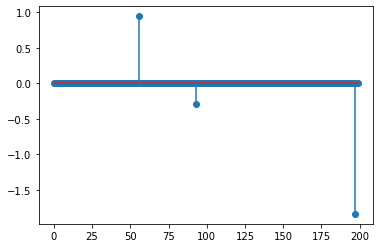

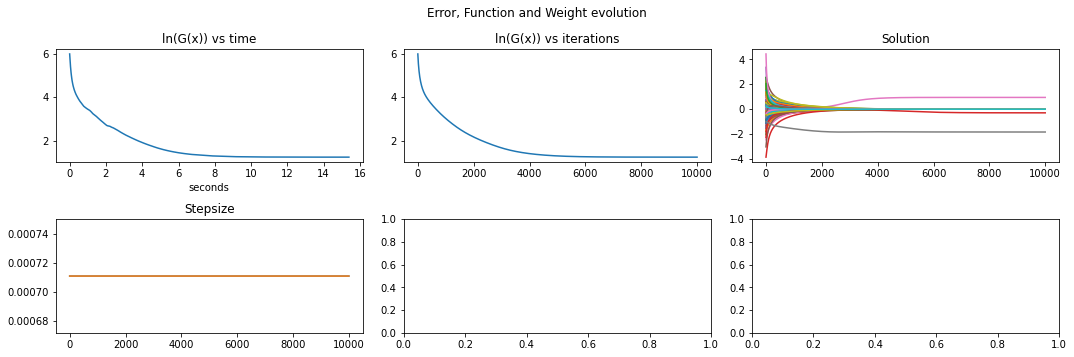

In [128]:
#Do gradient descent with step chosen using Armijo Backtracking Line Search
step = 0.001
niter = 10000
errvec3 = np.zeros(niter)
u = np.random.randn(samples)
v = np.random.randn(samples)
xtemp3 = np.zeros((samples,niter))
funcvec_gda = np.zeros(niter)
steparr = np.zeros((2,niter))
time_gda = np.zeros(niter)
start = time.time()
for i in range(niter):
    #rndindx = np.random.randint(0, samples, 1)[0]
    #ch_sample = A[:,rndindx].reshape(-1,1)
    gradu = GnabU(u,v,A,y,lam)
    gradv = GnabV(u,v,A,y,lam)
    stepu = LineSearchU(u,v,A,y,lam)
    stepv = LineSearchV(u,v,A,y,lam)
    steparr[0,i] = stepu
    steparr[1,i] = stepv
    u = u - stepu*gradu
    v = v - stepv*gradv
    x = u * v
    xtemp3[:,i] = x
    errvec3[i] = errL2(A,x,y)
    funcvec_gda[i] = funcreg(A,x,y,lam)
    time_gda[i] = time.time() - start
    #print(stepu)

end = time.time()

print('Time for', niter, 'iterations:', end - start, 'seconds')
print("Final f(x)+g(x):", funcvec_gda[-1])
print("Final soln:", x)
print("Subdifferential:", SubdifTest(A,x,y,lam))
plt.stem(x)
plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(time_gda,np.log(funcvec_gda.T));
axs3[0,0].set_title('ln(G(x)) vs time')
axs3[0,0].set_xlabel('seconds')
axs3[0,1].plot(np.log(funcvec_gda.T));
axs3[0,1].set_title('ln(G(x)) vs iterations')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')
fig.tight_layout(pad=1.0)

In [114]:
def BBstep(xt,xtm1,gradt,gradtm1):    #Function for Barzilai-Borwein stepsize
    eps = 10**(-30)
    st = xt - xtm1
    yt = gradt - gradtm1
    return (st.T @ st) / (abs((st.T @ yt)) + eps)

Time for 200 iterations: 0.32053375244140625 seconds
Final error: 3.4290917910836867
Final soln: [ 1.23236979e-47 -9.50398235e-45 -5.59207887e-29  9.35614862e-45
 -1.03882864e-41 -9.04020885e-40  1.23862658e-45 -3.97448849e-41
 -3.13747232e-47 -3.55547942e-45 -4.22998368e-42 -4.39028641e-48
 -3.65593074e-41 -4.19155046e-43 -6.04273483e-46  3.27104343e-45
  1.41980243e-44 -1.29533073e-38  5.28463808e-44 -4.43553467e-33
 -4.31390759e-45  1.53934538e-32 -6.57838385e-30 -3.08933325e-43
 -1.09783910e-43 -3.01415356e-44  1.26876948e-44  5.52258817e-36
  3.58719128e-40  1.40621937e-44 -8.90423687e-47  1.16241025e-45
  5.57902000e-44  7.64947373e-47 -1.83717113e-45 -3.93124158e-42
  3.69842734e-44 -5.28667436e-42  2.57738007e-46 -2.45629562e-49
  5.25778576e-44 -7.78167582e-39  1.53139160e-43  6.81963796e-45
  5.74051496e-46  2.46842974e-47 -3.04340055e-41 -3.25893017e-46
  2.36738401e-46 -5.16212650e-45  8.07678724e-43 -4.88912110e-47
  1.29042509e-46  3.68368051e-36 -6.33451724e-44  1.819127

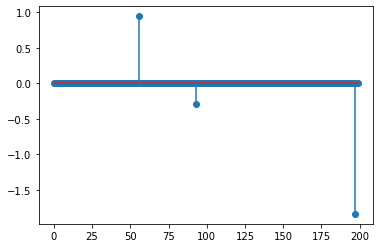

Text(0.5, 1.0, 'Stepsize')

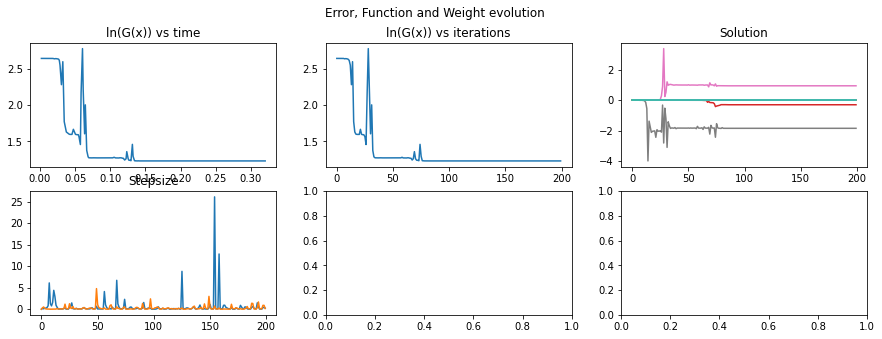

In [129]:
#Do gradient descent with step chosen using Barzilai-Borwein
step = 0.001
niter = 200
errvec3 = np.zeros(niter)
u = np.random.randn(samples)*0.0001
v = np.random.randn(samples)*0.0001
xtemp3 = np.zeros((samples,niter))
funcvec_gdb = np.zeros(niter)
steparr = np.zeros((2,niter))
uold = u
vold = v
time_gdb = np.zeros(niter)
start = time.time()
for i in range(niter):
    #rndindx = np.random.randint(0, samples, 1)[0]
    #ch_sample = A[:,rndindx].reshape(-1,1)
    gradu = GnabU(u,v,A,y,lam)
    gradv = GnabV(u,v,A,y,lam)
    #stepu = LineSearchU(u,v,ch_sample,y,lam)
    #stepv = LineSearchV(u,v,ch_sample,y,lam)
    stepu = .1/np.linalg.norm(A)
    stepv = .1/np.linalg.norm(A)
    if(i > 0):
        stepu = BBstep(u,uold,GnabU(u,v,A,y,lam),GnabU(uold,vold,A,y,lam))
        stepv = BBstep(v,vold,GnabV(u,v,A,y,lam),GnabV(uold,vold,A,y,lam))
    
    steparr[0,i] = stepu
    steparr[1,i] = stepv
    uold = u
    vold = v
    u = u - stepu*gradu
    v = v - stepv*gradv
    x = u * v
    xtemp3[:,i] = x
    errvec3[i] = errL2(A,x,y)
    funcvec_gdb[i] = funcreg(A,x,y,lam)
    time_gdb[i] = time.time() - start
    
end = time.time()

print('Time for', niter, 'iterations:', end - start, 'seconds')
    
print("Final error:", funcvec_gdb[-1])
print("Final soln:", x)
print("Subdifferential:", SubdifTest(A,x,y,lam))
plt.stem(x)
plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,1].plot(np.log(funcvec_gdb.T));
axs3[0,1].set_title('ln(G(x)) vs iterations')
axs3[0,0].plot(time_gdb,np.log(funcvec_gdb.T));
axs3[0,0].set_title('ln(G(x)) vs time')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

In [27]:
#Now try with real data - load MNIST digits
#(train_X, train_y), (test_X, test_y) = mnist.load_data()

# Stochastic Gradient Descent
Now, note that
$$\frac{1}{2}\|Ax-y\|_2^2 = \frac{1}{2}\sum^m_{i=1} \left(\langle A_i, x \rangle - y_i \right)^2 = \frac{1}{2}\sum^m_{i=1} Q_i = \frac{1}{2}\sum^m_{i=1} L_i^2 $$

Thus, a partial derivative w.r.t $x_i$ is just
$$\nabla Q_i(x) = L_i \cdot A_i^T,$$

where $A_i$ is the $i$-th row of the matrix $A$, corresponding to the $i$-th sample.

Furrthermore, if we have that $x = u \odot v,$ then by chain rule we have
$$\nabla_u Q_i(x) = L_i \cdot A_i^T \odot v.$$
$$\nabla_v Q_i(x) = L_i \cdot A_i^T \odot u.$$

In [117]:
#Check that sum of gradient is gradient of the sum
x = np.zeros(samples)
diff = A@x-y
grad = np.zeros(samples)
for i in range(features):
    grad = grad + diff[i] * A[i,:].T
    
print(np.linalg.norm(grad - GradF(A,x,y)))

1.4989392379641386e-13


In [118]:
print(np.size(A,0))

100


In [119]:
def SGnabV(u,v,X,y,lam,indx):             #Stochastic Gradient for V
    Xi = X[indx,:]
    features = np.size(X,0)
    Li = Xi @ (u*v) - y[indx]
    return v + (1/lam)*features*u*(Xi @ (u*v) - y[indx])*Xi.T
    #return lam*v + features*u*(Xi @ (u*v) - y[indx])*Xi.T

In [120]:
def SGnabU(u,v,X,y,lam,indx):             #Stochastic Gradient for U
    Xi = X[indx,:]
    features = np.size(X,0)
    Li = Xi @ (u*v) - y[indx]
    return u + (1/lam)*features*v*(Xi @ (u*v) - y[indx])*Xi.T
    #return lam*u + features*u*(Xi @ (u*v) - y[indx])*Xi.T

Time for 400000 iterations: 42.15221405029297 seconds
Final f(x)+g(x): 3.429130284215935
|x-x0|_0 = 200.0
Subdifferential: 1.0145534220758843


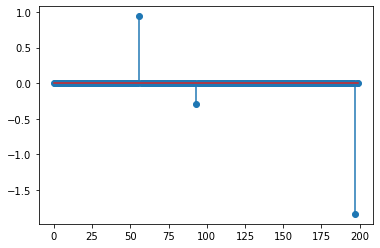

Text(0.5, 1.0, 'Stepsize')

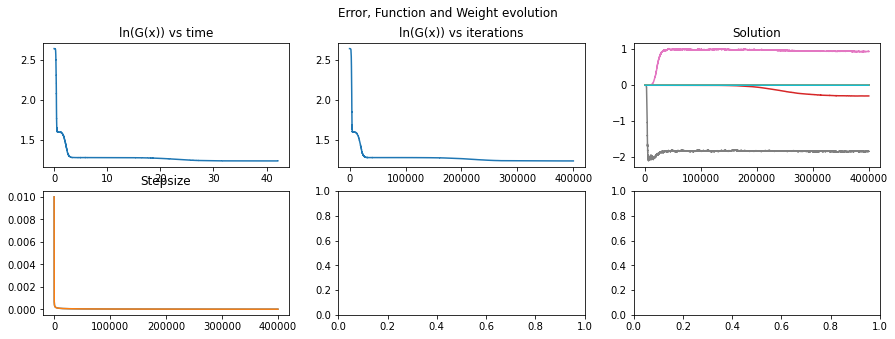

In [139]:
#Do SGD with decaying stepsize omg_k = omg_0 / (1 + k/10)
step = 0.001
niter = 400000
errvec3 = np.zeros(niter)
u = np.random.randn(samples)*0.0001
v = np.random.randn(samples)*0.0001
xtemp3 = np.zeros((samples,niter))
funcvec_sgd = np.zeros(niter)
steparr = np.zeros((2,niter))
time_sgd = np.zeros(niter)
start = time.time()
for i in range(niter):
    rndindx = np.random.randint(features)
    #ch_sample = A[:,rndindx].reshape(-1,1)
    gradu = SGnabU(u,v,A,y,lam,rndindx)
    gradv = SGnabV(u,v,A,y,lam,rndindx)
    stepu = 0.01/(1+i)**0.51
    stepv = 0.01/(1+i)**0.51
    steparr[0,i] = stepu
    steparr[1,i] = stepv
    u = u - stepu*gradu
    v = v - stepv*gradv
    x = u * v
    xtemp3[:,i] = x
    funcvec_sgd[i] = funcreg(A,x,y,lam)
    #print(stepu)
    time_sgd[i] = time.time() - start
    
end = time.time()

print('Time for', niter, 'iterations:', end - start, 'seconds')
    
print("Final f(x)+g(x):", funcvec_sgd[-1])
#print("Final soln:", x)
#print("Original soln:", x0)
print("|x-x0|_0 =", np.linalg.norm(x-x0,0))
print("Subdifferential:", SubdifTest(A,x,y,lam))
plt.stem(u*v)
plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(time_sgd,np.log(funcvec_sgd.T));
axs3[0,0].set_title('ln(G(x)) vs time')
axs3[0,1].plot(np.log(funcvec_sgd.T));
axs3[0,1].set_title('ln(G(x)) vs iterations')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

In [28]:
def BBstep(xt,xtm1,gradt,gradtm1):    #Function for Barzilai-Borwein stepsize
    st = xt - xtm1
    yt = gradt - gradtm1
    return (st.T @ st) / abs((st.T @ yt))

In [29]:
def SGD_BB_k(xt,xtm1,gradt,gradtm1,Ckm1,phik,k,epoch_sz):    #Smoothing technique for the SGD BB step
    st = xt - xtm1
    yt = gradt - gradtm1
    bbk = (1/epoch_sz)*(st.T @ st) / abs((st.T @ yt))
    Ckopt = (bbk * phik) ** (1/(k-1))
    Ckm1opt = Ckm1 ** ((k-2)/(k-1))
    return Ckm1opt * Ckopt

Time for 30000 iterations: 155.71631693840027 seconds
Final f(x)+g(x): 3.574955070966876
Final soln: [ 1.15036843e-12 -3.08084405e-12 -2.20805450e-09  8.19449593e-13
 -3.93864151e-12 -5.62880097e-11  2.91776971e-11 -6.35062131e-10
 -5.72209988e-13  4.83773583e-15 -2.92461039e-11  3.23664090e-13
  2.83220541e-10 -1.70572245e-12 -5.11134283e-15  2.53374221e-11
  3.29573675e-12 -1.16065334e-11  4.15914069e-15 -2.31685783e-10
  5.74093768e-15  6.60887962e-12 -1.36764385e-10 -2.16724982e-12
 -1.22857267e-12 -2.66146634e-12 -1.52003084e-14  2.03472730e-10
  5.04198853e-12  7.62604232e-16 -5.07061691e-14  8.40193824e-14
  7.31114418e-13  3.48839733e-12 -5.84929960e-13 -4.64753809e-12
 -1.49045076e-12 -2.44700482e-11  1.78326289e-13  1.02882441e-14
 -8.31219424e-12 -7.61289209e-11  2.62985442e-14 -2.10843635e-15
  9.23424923e-14  4.54167942e-13 -5.81548252e-12 -3.48606701e-11
  1.07046672e-12 -8.22536113e-13  8.05380868e-11 -1.20204952e-13
  3.82601819e-12  8.04638049e-10 -4.86812448e-13  9.29

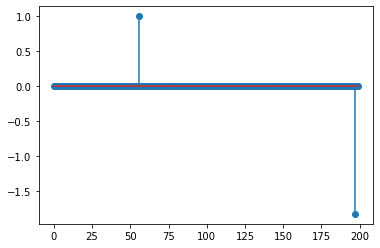

Text(0.5, 1.0, 'Stepsize')

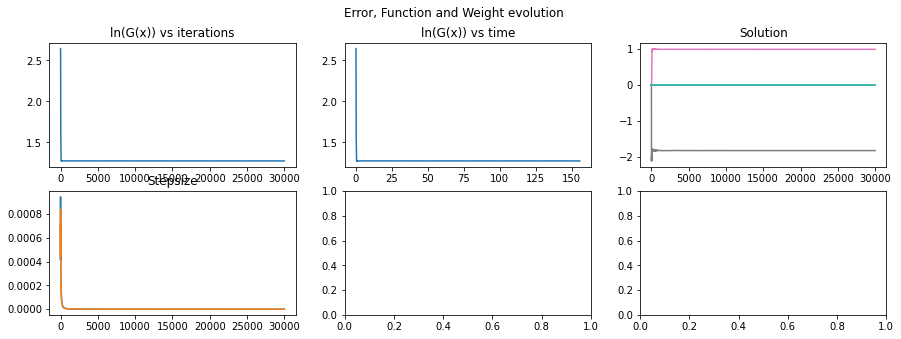

In [143]:
#Do stochastic gradient descent with step chosen using Barzilai-Borwein (SGD-BB in the paper)
step = 0.001
niter = 30000
u = np.random.randn(samples)*0.0001
v = np.random.randn(samples)*0.0001
xtemp = np.zeros((samples,niter))
funcvec_sgd_bb = np.zeros(niter)
steparr = np.zeros((2,niter))
uold = u
vold = v
epoch_sz = features
epoch_u = 0
epoch_v = 0
beta = 10/(features)
time_sgd_bb = np.zeros(niter)
start = time.time()
for i in range(niter):
    phik = 1 + i
    
    if(i > 1):
        Ckm1u = SGD_BB_k(u,uold,gradu_avg,gradu_avg_old,Ckm1u,phik,i,epoch_sz)
        Ckm1v = SGD_BB_k(v,vold,gradv_avg,gradv_avg_old,Ckm1v,phik,i,epoch_sz)
        stepu = Ckm1u / phik
        stepv = Ckm1v / phik
        #stepu = (1/epoch_sz) * BBstep(u,uold,gradu_avg,gradu_avg_old)
        #stepv = (1/epoch_sz) * BBstep(v,vold,gradv_avg,gradv_avg_old)
        steparr[0,i] = stepu
        steparr[1,i] = stepv
    
    uold = u
    vold = v
    if (i <= 1):
        Ckm1u = 1
        Ckm1v = 1
        stepu = .1/np.linalg.norm(A)
        stepv = .1/np.linalg.norm(A)
        steparr[0,i] = stepu
        steparr[1,i] = stepv
        gradu_avg = 0
        gradv_avg = 0
    gradu_avg_old = gradu_avg
    gradv_avg_old = gradv_avg
    gradu_avg = 0
    gradv_avg = 0
    for t in range(epoch_sz):
        rndindx = np.random.randint(0, features)
        gradu = SGnabU(u,v,A,y,lam,rndindx)
        gradv = SGnabV(u,v,A,y,lam,rndindx)
        u = u - stepu * gradu
        v = v - stepv * gradv
        gradu_avg = beta * gradu + (1-beta) * gradu_avg
        gradv_avg = beta * gradv + (1-beta) * gradv_avg
    
    xtemp[:,i] = u * v
    funcvec_sgd_bb[i] = funcreg(A,(u * v),y,lam)
    time_sgd_bb[i] = time.time() - start
    
end = time.time()

print('Time for', niter, 'iterations:', end - start, 'seconds')
print("Final f(x)+g(x):", funcvec_sgd_bb[-1])
print("Final soln:", u * v)
print("Subdifferential:", SubdifTest(A,u * v,y,lam))
plt.stem(u*v)
plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,1].plot(time_sgd_bb,np.log(funcvec_sgd_bb.T));
axs3[0,1].set_title('ln(G(x)) vs time')
axs3[0,0].plot(np.log(funcvec_sgd_bb.T));
axs3[0,0].set_title('ln(G(x)) vs iterations')
axs3[0,2].plot(xtemp.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

# SVRG-BB



Time for 15 iterations: 0.4220290184020996 seconds
Final f(x)+g(x): 3.429091797230846
Subdifferential: 1.000190482182791


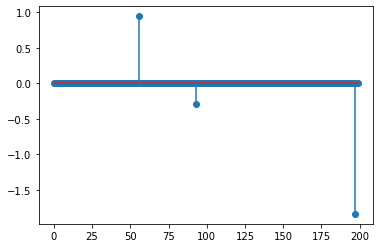

Text(0.5, 1.0, 'Stepsize')

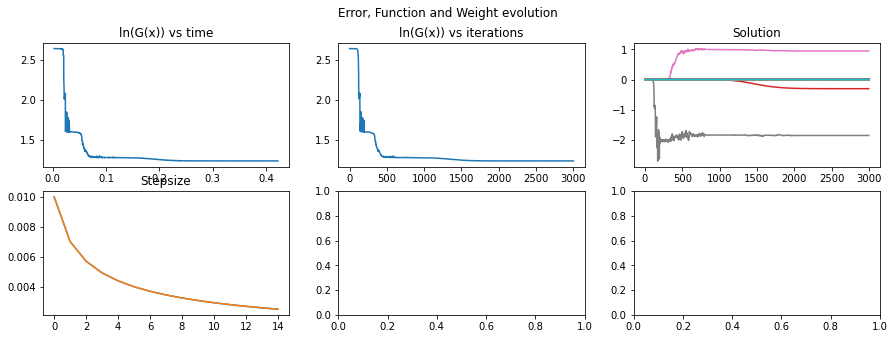

In [149]:
#Do SVRG with decreasing stepsize
step = 0.001
niter = 15
errvec3 = np.zeros(niter)
u = np.random.randn(samples)*0.0001
v = np.random.randn(samples)*0.0001
xtemp3 = np.zeros((samples,niter))
epoch_sz = 2*features
funcvec_svr = np.zeros(niter*epoch_sz)
steparr = np.zeros((2,niter))
xtemp3 = np.zeros((samples,niter*epoch_sz))
time_svr = np.zeros(niter*epoch_sz)
start = time.time()
for i in range(niter):
    gradu_rl = GnabU(u,v,A,y,lam)
    gradv_rl = GnabV(u,v,A,y,lam)
    stepu = 0.01/(1+i)**0.51
    stepv = 0.01/(1+i)**0.51
    steparr[0,i] = stepu
    steparr[1,i] = stepv
    x = u * v
    #xtemp3[:,i] = x
    #funcvec3[i] = funcreg(A,x,y,lam)
    u0 = u
    v0 = v
    for j in range(epoch_sz):
        rndindx = np.random.randint(features)
        gradu = SGnabU(u,v,A,y,lam,rndindx)
        gradv = SGnabV(u,v,A,y,lam,rndindx)
        gradu0 = SGnabU(u0,v0,A,y,lam,rndindx)
        gradv0 = SGnabV(u0,v0,A,y,lam,rndindx)
        u = u - stepu*(gradu_rl + gradu - gradu0)
        v = v - stepv*(gradv_rl + gradv - gradv0)
        x = u * v
        xtemp3[:,i*epoch_sz+j] = x
        funcvec_svr[i*epoch_sz+j] = funcreg(A,x,y,lam)
        time_svr[i*epoch_sz+j] = time.time() - start
    
end = time.time()

print('Time for', niter, 'iterations:', end - start, 'seconds')
    
print("Final f(x)+g(x):", funcvec_svr[-1])
#print("Final soln:", x)
#print("Original soln:", x0)
print("Subdifferential:", SubdifTest(A,x,y,lam))
plt.stem(u*v)
plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(time_svr,np.log(funcvec_svr.T));
axs3[0,0].set_title('ln(G(x)) vs time')
axs3[0,1].plot(np.log(funcvec_svr.T));
axs3[0,1].set_title('ln(G(x)) vs iterations')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

Time for 30 iterations: 0.8422636985778809 seconds
Final f(x)+g(x): 3.4290917910837235
Final soln: [ 8.70687444e-20 -8.85750668e-22 -3.28855128e-14  3.49175748e-23
 -8.21933836e-22 -8.29205994e-17  1.64865611e-20 -2.79338234e-19
 -5.40926000e-22 -1.30008234e-22 -2.43561428e-20  3.19098495e-21
  8.89103864e-21 -1.16540882e-20 -1.83854504e-20  5.34962377e-20
  3.66064413e-20 -1.07818046e-17  4.79931307e-25 -4.43700176e-16
 -7.60320648e-24  1.04810758e-19 -1.95231179e-14 -1.55960436e-22
 -3.54253506e-21 -3.30958098e-23  5.97868054e-21  1.98512041e-17
  5.91158753e-18 -1.70671804e-20 -1.24231146e-22  1.49400135e-22
  5.83200441e-21  1.01189391e-21 -1.07966250e-22 -1.23204862e-18
 -1.26335339e-22 -1.71747318e-21  6.53064642e-22 -7.38417715e-24
 -2.17512774e-20 -1.47795808e-17  2.91848889e-22  2.27317249e-22
 -3.66890408e-23  2.32621705e-21 -7.46586580e-24 -1.18880772e-20
  8.82691920e-22 -1.65498386e-22  1.28089814e-20  5.64323535e-22
 -7.88713847e-24  2.26050917e-18 -1.34551293e-19  1.0641

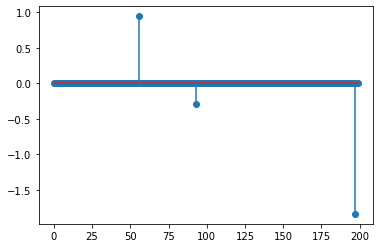

Text(0.5, 1.0, 'Stepsize')

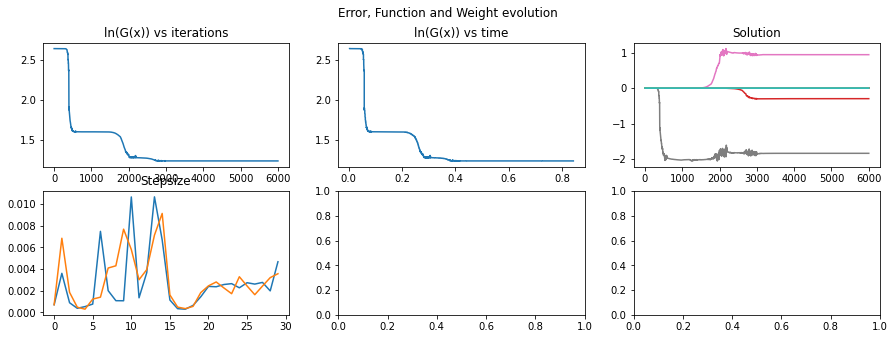

In [155]:
#Do SVRG-BB
step = 0.001
niter = 30
epoch_sz = 2*features
u = np.random.randn(samples)*0.0001
v = np.random.randn(samples)*0.0001
xtemp = np.zeros((samples,niter*epoch_sz))
funcvec_svr_bb = np.zeros(niter*epoch_sz)
steparr = np.zeros((2,niter))
uold = u
vold = v
epoch_u = 0
epoch_v = 0
beta = 10/(features)
gradu_rl = GnabU(u,v,A,y,lam)
gradv_rl = GnabV(u,v,A,y,lam)
time_svr_bb = np.zeros(niter*epoch_sz)
start = time.time()
for i in range(niter):
    gradu_rl_old = gradu_rl
    gradv_rl_old = gradv_rl
    gradu_rl = GnabU(u,v,A,y,lam)
    gradv_rl = GnabV(u,v,A,y,lam)
    
    if(i > 0):
        stepu = (1/epoch_sz) * BBstep(u,uold,gradu_rl,gradu_rl_old)
        stepv = (1/epoch_sz) * BBstep(v,vold,gradv_rl,gradv_rl_old)
        steparr[0,i] = stepu
        steparr[1,i] = stepv
    
    uold = u
    vold = v
    if (i == 0):
        stepu = .1/np.linalg.norm(A)
        stepv = .1/np.linalg.norm(A)
        steparr[0,i] = stepu
        steparr[1,i] = stepv

    for t in range(epoch_sz):
        rndindx = np.random.randint(features)
        gradu = SGnabU(u,v,A,y,lam,rndindx)
        gradv = SGnabV(u,v,A,y,lam,rndindx)
        gradu0 = SGnabU(uold,vold,A,y,lam,rndindx)
        gradv0 = SGnabV(uold,vold,A,y,lam,rndindx)
        u = u - stepu*(gradu_rl + gradu - gradu0)
        v = v - stepv*(gradv_rl + gradv - gradv0)
        x = u * v
        xtemp[:,i*epoch_sz+t] = x
        funcvec_svr_bb[i*epoch_sz+t] = funcreg(A,x,y,lam)
        time_svr_bb[i*epoch_sz+t] = time.time() - start
    
end = time.time()

print('Time for', niter, 'iterations:', end - start, 'seconds')
    
print("Final f(x)+g(x):", funcvec_svr_bb[-1])
print("Final soln:", u * v)
print("Subdifferential:", SubdifTest(A,u * v,y,lam))
plt.stem(u*v)
plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,1].plot(time_svr_bb,np.log(funcvec_svr_bb.T));
axs3[0,1].set_title('ln(G(x)) vs time')
axs3[0,0].plot(np.log(funcvec_svr_bb.T));
axs3[0,0].set_title('ln(G(x)) vs iterations')
axs3[0,2].plot(xtemp.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

In [42]:
def LineSearchSU(u,v,X,y,lam):            #Define the Armijo Backtracking Linesearch to find stepsize for u minimization
    tau = 1/2
    c = 1/2
    omg = .1/np.linalg.norm(X)
    grad = SGnabU(u,v,X,y,lam)
    t = -c * grad.T @ grad
    while(Gux(u,v,X,y,lam) - Gux((u - omg*grad),v,X,y,lam) < omg*t):
        omg = tau*omg
        
    return omg

Time for 6000 iterations: 12.738750696182251 seconds
Final f(x)+g(x): 3.52942408785804
Final soln: [ 2.06256591e-04 -2.25970790e-05 -8.68668277e-03 -5.84256151e-06
 -2.31554805e-04 -3.21916117e-03  6.99745087e-04 -5.17247243e-05
 -2.45955906e-04 -1.46163329e-06 -2.65686066e-04  5.86586511e-05
 -1.51025712e-05 -7.84289029e-04 -1.68450857e-03 -4.26711407e-05
  1.05436556e-03 -1.67773802e-03 -6.25987344e-05 -1.48312422e-03
  1.80257806e-04  1.93684197e-03 -5.47905162e-04 -2.01802196e-04
 -1.14489778e-03 -1.52932535e-06 -1.66844005e-04  4.84158461e-05
  1.83949892e-04 -5.31672343e-08  3.42691892e-04  4.26079373e-04
  3.40246826e-04  2.22326134e-04 -8.71666000e-05 -8.60684227e-04
 -7.86706882e-04 -4.46079069e-05  1.29830069e-03 -3.63090146e-04
 -2.46665073e-04 -1.78601394e-03  2.01935681e-04  3.37336851e-04
 -1.42709349e-05  2.71991799e-03 -7.69621135e-04 -6.91952714e-05
 -4.92907954e-05 -8.24472743e-05  1.02410640e-03  1.41562653e-04
  1.87815890e-04  3.36623583e-03 -2.06466936e-03  9.6935

Text(0.5, 1.0, 'Stepsize')

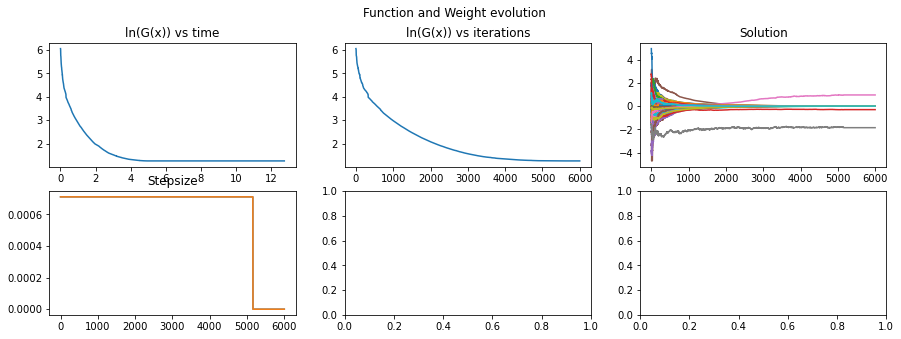

In [156]:
#Do stochastic gradient descent with step chosen using Armijo Backtracking Line Search
step = 0.001
niter = 6000
errvec3 = np.zeros(niter)
u = np.random.randn(samples)
v = np.random.randn(samples)
xtemp3 = np.zeros((samples,niter))
funcvec_sgd_ar = np.zeros(niter)
steparr = np.zeros((2,niter))
time_sgd_ar = np.zeros(niter)
start = time.time()
for i in range(niter):
    rndindx = np.random.randint(0, features)
    gradu = SGnabU(u,v,A,y,lam,rndindx)
    gradv = SGnabV(u,v,A,y,lam,rndindx)
    stepu = LineSearchU(u,v,A,y,lam)
    stepv = LineSearchV(u,v,A,y,lam)
    steparr[0,i] = stepu
    steparr[1,i] = stepv
    u = u - stepu*gradu
    v = v - stepv*gradv
    x = u * v
    xtemp3[:,i] = x
    errvec3[i] = errL2(A,x,y)
    funcvec_sgd_ar[i] = funcreg(A,x,y,lam)
    time_sgd_ar[i] = time.time() - start
    #print(stepu)
    
end = time.time()
print('Time for', niter, 'iterations:', end - start, 'seconds') 
print("Final f(x)+g(x):", funcvec_sgd_ar[-1])
print("Final soln:", x)
print("Subdifferential:", SubdifTest(A,x,y,lam))

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Function and Weight evolution')
axs3[0,0].plot(time_sgd_ar,np.log(funcvec_sgd_ar.T));
axs3[0,0].set_title('ln(G(x)) vs time')
axs3[0,1].plot(np.log(funcvec_sgd_ar.T));
axs3[0,1].set_title('ln(G(x)) vs iterations')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

# Stochastic Forward-Backward

We modify the F-B algorithm to work with SGD, rather than batch descent.

We have the F-B iteration
$$x_{n+1} = prox_{\gamma R}\left(x_n - \gamma \nabla_{i} f(x_n)\right).$$
That is,
$$x_{n+1} = prox_{\gamma R}\left(x_n - \frac{\gamma}{m} \sum_{j=1}^m g_j\right),$$
where
$$\mathbb{E} \left(g_j \right) = \nabla f(x_n)$$
and
$$ g_j = \frac{1}{\lambda}L_i \cdot A_i^T,$$
with $prox, L_i, A_i$ as above.

In [47]:
def SGnabX(X,x,y,lam,indx):             #Stochastic Gradient for V
    Xi = X[indx,:]
    Li = Xi @ x - y[indx]
    features = np.size(X,0)
    return features*Li*Xi.T

Time for 15000 iterations: 1.5359666347503662 seconds
Final f(x)+g(x): 3.4714107457330283
Final soln: [-1.90438480e-04 -8.65788895e-05 -2.10240817e-04  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -3.49086390e-04 -0.00000000e+00
  7.63356809e-05 -1.27628193e-04 -1.80024918e-04  1.21846709e-04
  5.61076634e-05  1.47660032e-04  0.00000000e+00  3.06629746e-04
 -2.72326379e-04 -3.71479067e-04 -3.43451957e-04 -6.21164702e-04
  2.02491119e-04 -4.98473117e-04 -9.02903947e-05 -2.70341648e-04
 -1.06024022e-03  0.00000000e+00  0.00000000e+00 -1.93790900e-05
 -3.68667213e-05 -5.02546461e-04 -1.00523937e-06 -0.00000000e+00
 -1.16068155e-03 -7.03582678e-05  0.00000000e+00  4.30868931e-04
 -3.42264512e-04  1.98778941e-04  0.00000000e+00  8.66513527e-04
 -5.97571814e-04 -1.12686287e-04  9.21569278e-04 -6.41399867e-05
 -0.00000000e+00  6.31056809e-05  1.28361671e-04  3.19793570e-04
 -3.91432964e-05  1.63083868e-04 -0.00000000e+00 -3.11303865e-04
 -7.79394000e-05  3.24828232e-04 -5.99799580e-04  0.0

Text(0.5, 1.0, 'Solution')

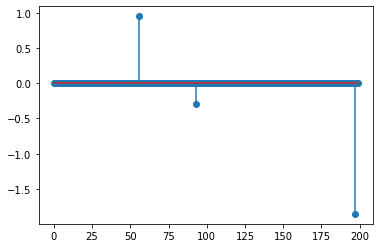

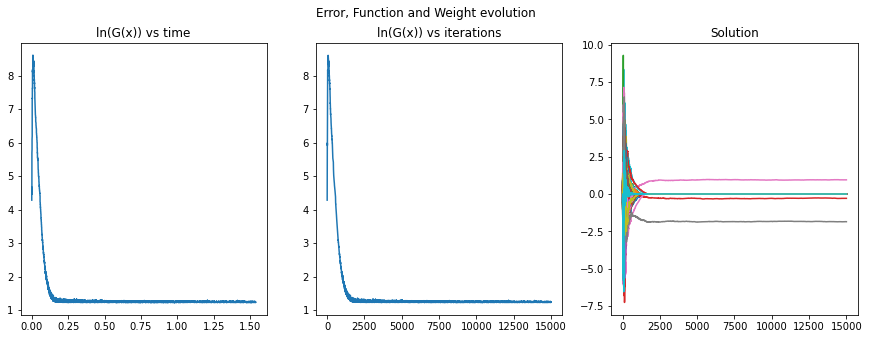

In [158]:
#Implement batch SGD Forward Backward alg
#initialize x_0 = 0
u = np.random.randn(samples)*0.0001
v = np.random.randn(samples)*0.0001
x = u*v;
#x = np.random.randn(samples)
niter = 15000
xtemp = np.zeros((samples,niter))
errvec = np.zeros(niter)
funcvec_fb_sgd = np.zeros(niter)
omg = .1/np.linalg.norm(A)
omgk = omg
time_fb_sgd = np.zeros(niter)
#mbs = round(features*0.8)        #minibatch size
start = time.time()
for i in range(niter):
    grad = np.zeros(samples)
    rndindx = np.random.randint(features)
    #for j in range(mbs):          #Iterate over minibatch
    #    rndindx = np.random.randint(0, features)
    #    grad = grad + SGnabX(A,x,y,lam,rndindx)
    
    #grad = (1/mbs)*grad              #<---  It seems dividing by the batch size causes the algorithm to perform worse.
    grad = SGnabX(A,x,y,lam,rndindx)
    omgk = 0.001/(1+i)**0.51
    x = prox(x - omgk*grad,omgk*lam)
    xtemp[:,i] = x
    funcvec_fb_sgd[i] = funcreg(A,x,y,lam)
    time_fb_sgd[i] = time.time() - start
    
end = time.time()
print('Time for', niter, 'iterations:', end - start, 'seconds') 
print("Final f(x)+g(x):", funcvec_fb_sgd[-1])
print("Final soln:", x)
print("Subdifferential:", SubdifTest(A,x,y,lam))
plt.stem(x)

fig, axs4 = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs4[0].plot(time_fb_sgd,np.log(funcvec_fb_sgd.T));
axs4[0].set_title('ln(G(x)) vs time')
axs4[1].plot(np.log(funcvec_fb_sgd.T));
axs4[1].set_title('ln(G(x)) vs iterations')
axs4[2].plot(xtemp.T);
axs4[2].set_title('Solution')


# Dual Averaging Method

In [49]:
def RDAstep(gt,t,lam,rho,gamma):
    lRDA = lam + rho/np.sqrt(t)
    x = np.zeros(np.size(gt))
    for i in range(np.size(gt)):
        if abs(gt[i]) <= lRDA:
            x[i] = 0
        else:
            x[i] = (-np.sqrt(t) / gamma) * (gt[i] - lRDA*np.sign(gt[i]))
            
    return x

Time for 70000 iterations: 16.950486660003662 seconds
Final f(x)+g(x): 3.477340572943716
Final soln: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.87512888  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.  

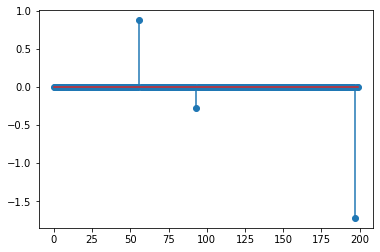

<ipython-input-160-210c266fcc4a>:34: RuntimeWarning: divide by zero encountered in log
  axs5[0].plot(time_rda,np.log(funcvec_rda.T));
<ipython-input-160-210c266fcc4a>:38: RuntimeWarning: divide by zero encountered in log
  axs5[1].plot(np.log(funcvec_rda.T));


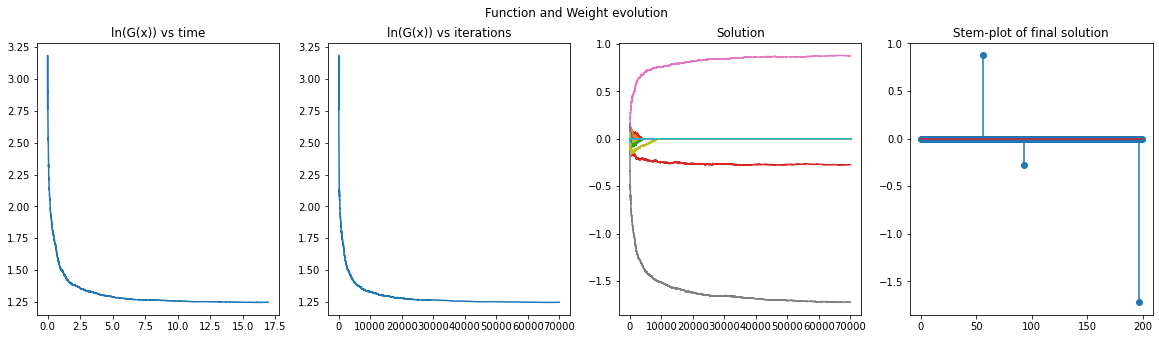

In [160]:
#Incorporate the RDA method as defined in paper by Lin Xiao
x = np.zeros(samples)
gt = np.zeros(samples)
niter = 70000
xtemp = np.zeros((samples,niter))
errvec = np.zeros(niter)
funcvec_rda = np.zeros(niter)
omg = .1/np.linalg.norm(A)
rho = 0.001
gamma = 5000
gtavg = np.zeros(samples)
time_rda = np.zeros(niter)
#mbs = round(features*0.8)        #minibatch size
start = time.time()
for i in range(1,niter):
    rndindx = np.random.randint(features)
    gt = SGnabX(A,x,y,lam,rndindx)    
    gtavg = ((i-1)/i) * gtavg + (1/i) * gt
    x = RDAstep(gtavg,i,lam,rho,gamma)
    xtemp[:,i] = x
    funcvec_rda[i] = funcreg(A,x,y,lam)
    time_rda[i] = time.time() - start
    
end = time.time()
print('Time for', niter, 'iterations:', end - start, 'seconds')
print("Final f(x)+g(x):", funcvec_rda[-1])
print("Final soln:", x)
print("Subdifferential:", SubdifTest(A,x,y,lam))
plt.stem(x)
plt.show()

fig, axs5 = plt.subplots(1,4, figsize=(20,5))
fig.suptitle('Function and Weight evolution')
axs5[0].plot(time_rda,np.log(funcvec_rda.T));
axs5[0].set_title('ln(G(x)) vs time')
axs5[2].plot(xtemp.T);
axs5[2].set_title('Solution')
axs5[1].plot(np.log(funcvec_rda.T));
axs5[1].set_title('ln(G(x)) vs iterations')
axs5[3].stem(x);
axs5[3].set_title('Stem-plot of final solution')
plt.savefig('foo2.png')

Time for 50000 iterations: 29.794601440429688 seconds
Final f(x)+g(x): 3.433776248901626
|x-x0|_0 = 65.0
Subdifferential: 1.035188485219433


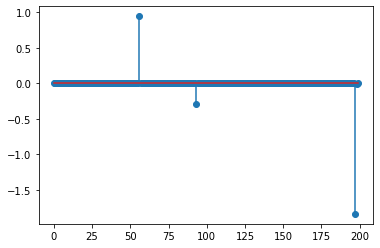

Text(0.5, 1.0, 'Solution')

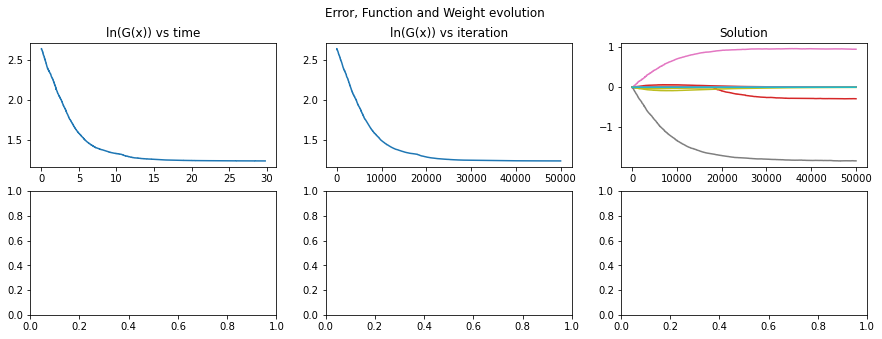

In [162]:
#Do ADAGRAD
step = 0.01
niter = 50000
errvec3 = np.zeros(niter)
u = np.random.randn(samples)*0.0001
v = np.random.randn(samples)*0.0001
xtemp3 = np.zeros((samples,niter))
funcvec_adgrd = np.zeros(niter)
diagradu = np.zeros(samples)
diagradv = np.zeros(samples)
#beta = 0.95
#steparr = np.zeros((2,niter))
omg = 0.01
eps = 10**(-8) * np.ones(samples) * 0
#eps = np.zeros(samples)
time_adgrd = np.zeros(niter)
start = time.time()
for i in range(niter):
    rndindx = np.random.randint(features)
    gradu = SGnabU(u,v,A,y,lam,rndindx)
    gradv = SGnabV(u,v,A,y,lam,rndindx)
    for j in range(samples):
        diagradu[j] = diagradu[j] + (gradu[j])**2
        diagradv[j] = diagradv[j] + (gradv[j])**2
    stepu = omg / np.sqrt(diagradu + eps)
    stepv = omg / np.sqrt(diagradv + eps)
    #steparr[0,i] = stepu
    #steparr[1,i] = stepv
    u = u - stepu * gradu
    v = v - stepv * gradv
    x = u * v
    xtemp3[:,i] = x
    funcvec_adgrd[i] = funcreg(A,x,y,lam)
    #print(stepu)
    time_adgrd[i] = time.time() - start

end = time.time()
print('Time for', niter, 'iterations:', end - start, 'seconds')
print("Final f(x)+g(x):", funcvec_adgrd[-1])
#print("Final soln:", x)
#print("Original soln:", x0)
print("|x-x0|_0 =", np.linalg.norm(x-x0,0))
print("Subdifferential:", SubdifTest(A,x,y,lam))
plt.stem(u*v)
plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(time_adgrd,np.log(funcvec_adgrd.T));
axs3[0,0].set_title('ln(G(x)) vs time')
axs3[0,1].plot(np.log(funcvec_adgrd.T));
axs3[0,1].set_title('ln(G(x)) vs iteration')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
#axs3[1,0].plot(steparr.T);
#axs3[1,0].set_title('Stepsize')

In [180]:
#Create quasi-newton step
def qn_step(H,grad):
    n = np.size(grad)
    step = np.zeros(n)
    for i in range(n):
        step[i] = grad[i]/(2*H[i,i])
    return step

Time for 10000 iterations: 24.17062497138977 seconds
Final f(x)+g(x): 3.433921060358071
|x-x0|_0 = 200.0
Subdifferential: 0.919048091067491


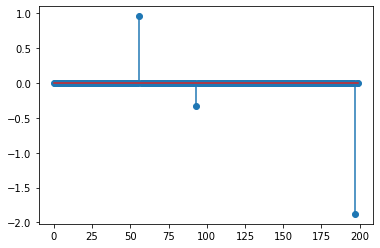

Text(0.5, 1.0, 'Solution')

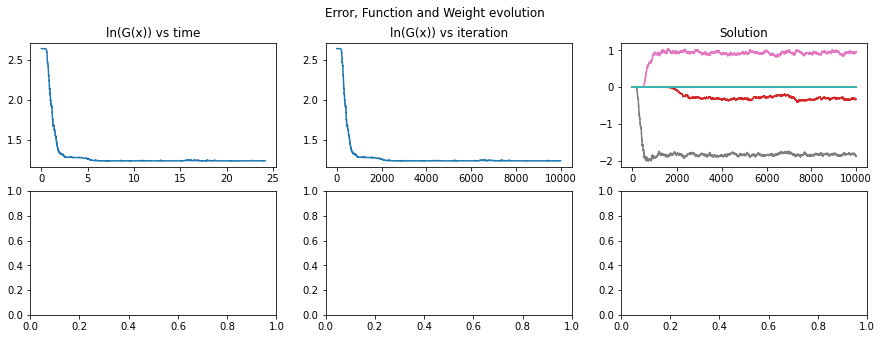

In [182]:
#Do Quasi-Newton using diagonal approximation for Hessian (similar to ADAGRAD)
step = 0.01
niter = 10000
errvec3 = np.zeros(niter)
u = np.random.randn(samples)*0.0001
v = np.random.randn(samples)*0.0001
xtemp3 = np.zeros((samples,niter))
funcvec_qn = np.zeros(niter)
omg = 0.01
time_qn = np.zeros(niter)
start = time.time()
AtA = A.T @ A
for i in range(niter):
    rndindx = np.random.randint(features)
    gradu = SGnabU(u,v,A,y,lam,rndindx)
    gradv = SGnabV(u,v,A,y,lam,rndindx)
    Hu = np.eye(samples) + (1/lam) * np.dot(np.dot(np.diag(v),AtA),np.diag(v))       #These two blocks form the diagonal of Hessian
    Hv = np.eye(samples) + (1/lam) * np.dot(np.dot(np.diag(u),AtA),np.diag(u))
    u = u - omg * qn_step(Hu,gradu)
    v = v - omg * qn_step(Hv,gradv)
    x = u * v
    xtemp3[:,i] = x
    funcvec_qn[i] = funcreg(A,x,y,lam)
    time_qn[i] = time.time() - start

end = time.time()
print('Time for', niter, 'iterations:', end - start, 'seconds')
print("Final f(x)+g(x):", funcvec_qn[-1])
#print("Final soln:", x)
#print("Original soln:", x0)
print("|x-x0|_0 =", np.linalg.norm(x-x0,0))
print("Subdifferential:", SubdifTest(A,x,y,lam))
plt.stem(u*v)
plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(time_qn,np.log(funcvec_qn.T));
axs3[0,0].set_title('ln(G(x)) vs time')
axs3[0,1].plot(np.log(funcvec_qn.T));
axs3[0,1].set_title('ln(G(x)) vs iteration')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
#axs3[1,0].plot(steparr.T);
#axs3[1,0].set_title('Stepsize')

Time for 30000 iterations: 45.677107095718384 seconds
Final f(x)+g(x): 3.430271103416608
|x-x0|_0 = 3.0
Subdifferential: 0.9805041331188037


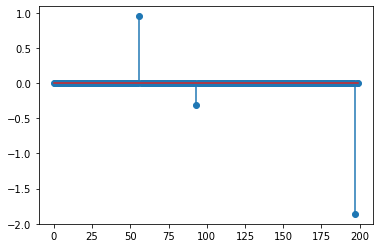

Text(0.5, 1.0, 'Solution')

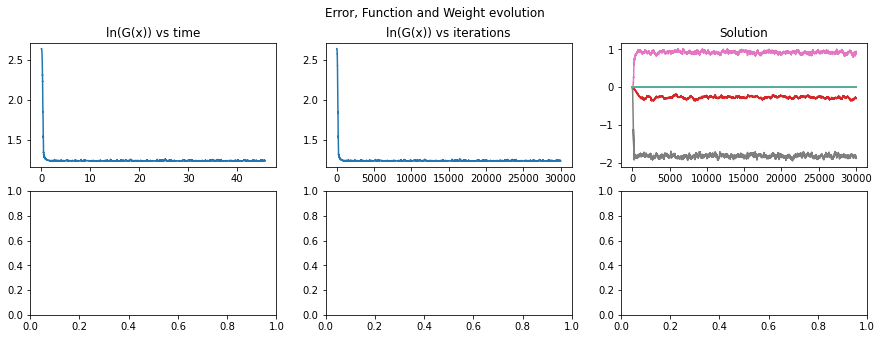

In [165]:
#Do ADADELTA
step = 0.01
niter = 30000
errvec3 = np.zeros(niter)
u = np.random.randn(samples)*0.0001
v = np.random.randn(samples)*0.0001
xtemp3 = np.zeros((samples,niter))
funcvec_addta = np.zeros(niter)
diagradu = np.zeros(samples)
diagradv = np.zeros(samples)
beta = 0.95
#steparr = np.zeros((2,niter))
omg = 0.01
eps = 10**(-6) * np.ones(samples)
#eps = np.zeros(samples)
rmsu = np.zeros(samples)
rmsv = np.zeros(samples)
time_addta = np.zeros(niter)
start = time.time()
for i in range(niter):
    rndindx = np.random.randint(features)
    gradu = SGnabU(u,v,A,y,lam,rndindx)
    gradv = SGnabV(u,v,A,y,lam,rndindx)
    for j in range(samples):
        diagradu[j] = beta*diagradu[j] + (1-beta)*(gradu[j])**2
        diagradv[j] = beta*diagradv[j] + (1-beta)*(gradv[j])**2
    stepu = np.sqrt(rmsu + eps) / np.sqrt(diagradu + eps)
    stepv = np.sqrt(rmsv + eps) / np.sqrt(diagradv + eps)
    #steparr[0,i] = stepu
    #steparr[1,i] = stepv
    stepgradu = stepu * gradu
    stepgradv = stepv * gradv
    u = u - stepgradu
    v = v - stepgradv
    for j in range(samples):
        rmsu[j] = beta*rmsu[j] + (1-beta)*(stepgradu[j])**2
        rmsv[j] = beta*rmsv[j] + (1-beta)*(stepgradv[j])**2
    x = u * v
    xtemp3[:,i] = x
    funcvec_addta[i] = funcreg(A,x,y,lam)
    time_addta[i] = time.time() - start
    #print(stepu)

end = time.time()
print('Time for', niter, 'iterations:', end - start, 'seconds')
print("Final f(x)+g(x):", funcvec3[-1])
#print("Final soln:", x)
#print("Original soln:", x0)
print("|x-x0|_0 =", np.linalg.norm(x-x0,0))
print("Subdifferential:", SubdifTest(A,x,y,lam))
plt.stem(u*v)
plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(time_addta,np.log(funcvec_addta.T));
axs3[0,0].set_title('ln(G(x)) vs time')
axs3[0,1].plot(np.log(funcvec_addta.T));
axs3[0,1].set_title('ln(G(x)) vs iterations')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
#axs3[1,0].plot(steparr.T);
#axs3[1,0].set_title('Stepsize')

Time for 5000 iterations: 6.303417682647705 seconds
Final f(x)+g(x): 3.430628547166858
|x-x0|_0 = 200.0
Subdifferential: 1.063997030863912


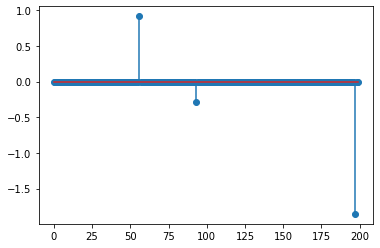

<ipython-input-166-e73d36804e16>:57: RuntimeWarning: divide by zero encountered in log
  axs3[0,0].plot(time_adam,np.log(funcvec_adam.T));
<ipython-input-166-e73d36804e16>:59: RuntimeWarning: divide by zero encountered in log
  axs3[0,1].plot(np.log(funcvec_adam.T));


Text(0.5, 1.0, 'Solution')

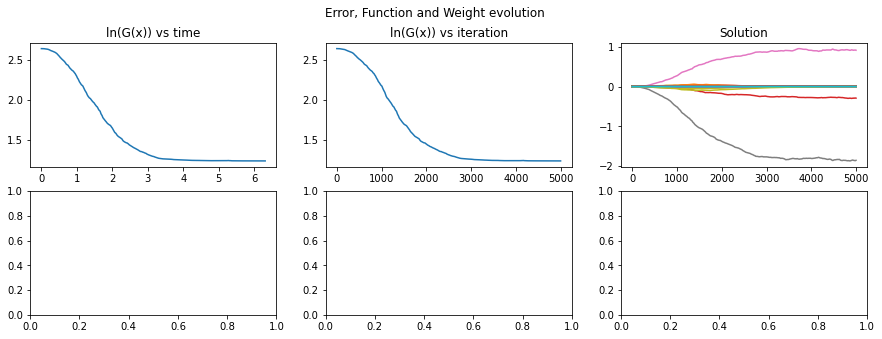

In [166]:
#Do ADAM
step = 0.01
niter = 5000
errvec3 = np.zeros(niter)
u = np.random.randn(samples)*0.0001
v = np.random.randn(samples)*0.0001
xtemp3 = np.zeros((samples,niter))
funcvec_adam = np.zeros(niter)
diagrad1u = np.zeros(samples)      #Initialize first moment estimate for u
diagrad1v = np.zeros(samples)      #Initialize first moment estimate for v
diagrad2u = np.zeros(samples)       #Initialize second moment estimate for u
diagrad2v = np.zeros(samples)       #Initialize second moment estimate for v
beta = 0.9        #Bias term for second moment estimate
beta2 = 0.999     #Bias term for first moment estimate
omg = 0.001        #Stepsize
eps = 10**(-8) * np.ones(samples)
time_adam = np.zeros(niter)
start = time.time()
for i in range(1,niter):
    rndindx = np.random.randint(features)
    gradu = SGnabU(u,v,A,y,lam,rndindx)
    gradv = SGnabV(u,v,A,y,lam,rndindx)
    for j in range(samples):
        diagrad1u[j] = beta*diagrad1u[j] + (1-beta)*(gradu[j])
        diagrad1v[j] = beta*diagrad1v[j] + (1-beta)*(gradv[j])
        diagrad2u[j] = beta2*diagrad2u[j] + (1-beta2)*(gradu[j])**2
        diagrad2v[j] = beta2*diagrad2v[j] + (1-beta2)*(gradv[j])**2
        
        
    if (i > 0):                                      #Implement bias correction
        diagrad1u_b = diagrad1u / (1 - beta**i)
        diagrad1v_b = diagrad1v / (1 - beta**i)
        diagrad2u_b = diagrad2u / (1 - beta2**i)
        diagrad2v_b = diagrad2v / (1 - beta2**i)
        
    stepu = omg * diagrad1u_b / (np.sqrt(diagrad2u_b) + eps)
    stepv = omg * diagrad1v_b / (np.sqrt(diagrad2v_b) + eps)
    u = u - stepu
    v = v - stepv
    x = u * v
    xtemp3[:,i] = x
    funcvec_adam[i] = funcreg(A,x,y,lam)
    time_adam[i] = time.time() - start

end = time.time()
print('Time for', niter, 'iterations:', end - start, 'seconds')
print("Final f(x)+g(x):", funcvec_adam[-1])
#print("Final soln:", x)
#print("Original soln:", x0)
print("|x-x0|_0 =", np.linalg.norm(x-x0,0))
print("Subdifferential:", SubdifTest(A,x,y,lam))
plt.stem(u*v)
plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(time_adam,np.log(funcvec_adam.T));
axs3[0,0].set_title('ln(G(x)) vs time')
axs3[0,1].plot(np.log(funcvec_adam.T));
axs3[0,1].set_title('ln(G(x)) vs iteration')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
#axs3[1,0].plot(steparr.T);
#axs3[1,0].set_title('Stepsize')

In [73]:
def ADGRDstep_temp(gt,t,lam,step):
    x = np.zeros(np.size(gt))
    for i in range(np.size(gt)):
        if abs(gt[i]) <= lam:
            x[i] = 0
        else:
            x[i] = step[i]**t * (gt[i] - lam*np.sign(gt[i]))
            
    return x

In [74]:
def ADGRDstep(t,lam,step,u):
    x = np.zeros(np.size(u))
    for i in range(np.size(u)):
        x[i] = np.sign(-u[i]) * step[i]**t * max(abs(u[i] / t) - lam,0)
            
    return x

Final f(x)+g(x): 14.04844618364119
Final soln: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.
  0.  0.  0. -0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0. -0.
  0.  0. -0.  0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0. -0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.
 -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0. -0.  0.  0. -0.  0.  0. -0.  0.  0.  0.  0.  0.
  0.  0. -0.  0.  0. -0.  0.  0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. -0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0. -0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
Subdifferential: 10.0


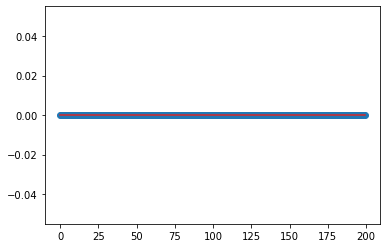

<ipython-input-75-f19be62d63be>:44: RuntimeWarning: divide by zero encountered in log
  axs5[1].plot(np.log(funcvec.T));


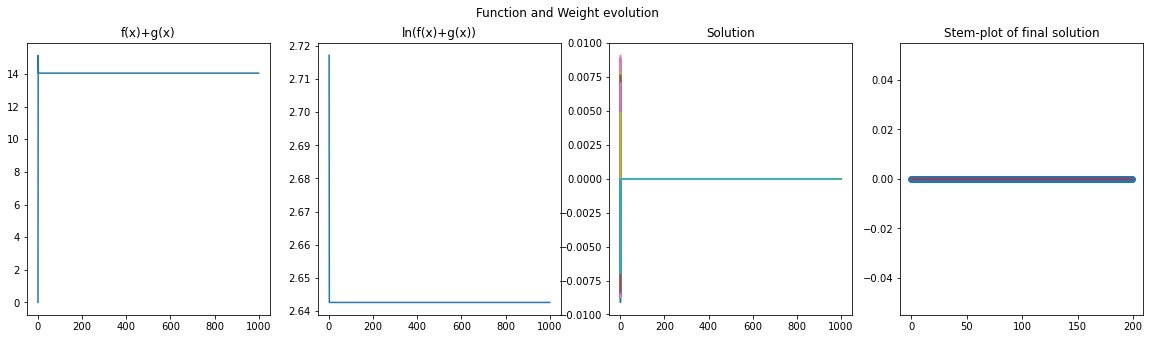

In [75]:
#Incorporate the L1-ADAGRAD method
#This isn't working yet
#x = np.random.randn(samples)*0.0001
x = np.zeros(samples)
gt = np.zeros(samples)
niter = 1000
xtemp = np.zeros((samples,niter))
errvec = np.zeros(niter)
funcvec = np.zeros(niter)
#omg = .1/np.linalg.norm(A)
omg = 0.01
rho = 0.005
gamma = 5000
gtavg = np.zeros(samples)
diagrad = np.zeros(samples)
eps = 10**(-8) * np.ones(samples)
u = np.zeros(samples)

for i in range(1,niter):
    rndindx = np.random.randint(features)
    gt = SGnabX(A,x,y,lam,rndindx)  
    gtavg = ((i-1)/i) * gtavg + (1/i) * gt
    u = i * gtavg
    for j in range(samples):
        diagrad[j] = diagrad[j] + (gt[j])**2
    step = omg / (np.sqrt(diagrad)+eps)
    x = ADGRDstep_temp(gtavg,i,lam,step)
    #x = ADGRDstep(i,lam,step,u)
    xtemp[:,i] = x
    funcvec[i] = funcreg(A,x,y,lam)
    
    
print("Final f(x)+g(x):", funcvec[-1])
print("Final soln:", x)
print("Subdifferential:", SubdifTest(A,x,y,lam))
plt.stem(x)
plt.show()

fig, axs5 = plt.subplots(1,4, figsize=(20,5))
fig.suptitle('Function and Weight evolution')
axs5[0].plot(funcvec.T);
axs5[0].set_title('f(x)+g(x)')
axs5[2].plot(xtemp.T);
axs5[2].set_title('Solution')
axs5[1].plot(np.log(funcvec.T));
axs5[1].set_title('ln(f(x)+g(x))')
axs5[3].stem(x);
axs5[3].set_title('Stem-plot of final solution')
plt.savefig('foo2.png')